
<a name="top"> <h1>3. FALSOS REEMPLAZOS - ISOLATION TREE</h1> <a>


<p>DECISION TREE - FALSOS REEMPLAZOS<br />
<strong>Price to Market Motor</strong><br />



<p style="text-align:right">Miguel D&iacute;az-Mauriño (<em>miguel.diaz@allianz.es</em>)</p>


# Setup notebooks

### General libraries

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import sys
import lightgbm as lgb
import re
import chardet
import shap

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### Logging

In [2]:
import logging

logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

### Load enviroment variables and adding to PYTHONPATH

In [3]:
from dotenv import load_dotenv
load_dotenv('.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

### Specific libraries

In [4]:
from src.utils import lgbm_feature_importance, decision_tree_model, label_encode_variables, plot_cramer, plot_lgb_importances, asignar_CCAA
# lgbm_feature_importance,
from src.load_functions import get_renames
from src.data_dict import formato, get_import_columns, get_dtypes_dict, get_rename_dict, get_features_model, get_features, get_feature_type, date_format

### Configuration dictionary

In [5]:
df = pd.read_parquet(os.path.join(data_root, 'FR_Tomador.parquet'))

df.head(5)

,POLIZA,APLICA,RAMO,prima_prop,PRIMA_ANT,PAQ_REPORTING,FRENOV,agrupacm,PRIMAN,MOTANUL,FANUL,FIANUL,CLASS_ANUL,Anulada,POLIZAN,APLICAN,CODPOST,POLIZAS_45,AGENTE,DC,SUCURSAL,USO,TOMADOR,TXCANAL,CODMEDP,CATTAG,AGRUPAGENTE,prima_reemplazante,prperiod,SINOCU,N_ANT,N_ACTUAL,Sdadpol_12M,DTO_DEFENSA,PRIMA_DEFENSA_ADPR,CORREDOR_PILOTO,sdad_total3p,sdad_total_tom,anualidad_seguro,Edad_conductor,APTP,rwCoeff_forced,retention,retention_def,Retencion_antes,TechPrice,num_stros_ultaño,num_stros_aga_ultaño,total_stros_ultaño,Valor_Mediador_Turismos,Prob_anul,CODMEDP_bnd,Prueba_Piloto_bnd,Super_rentables_bnd,Corredores_bnd,cltv_decile,Aleatorio,Segmentos_sept,segmento_deficiente_bnd,CAPTOTAL_vida,Edad_tomador_bnd,empleados,POL_VIDA,bm_anualidad,BM_cat,IsBMP,Random,Random_22,DEFENDIBLE,bm_ampliado,Stros2,CS,Provincia,m_anul,Sdadpol_12M_anterior,stros_anterior,defendida_SAS,defendida_ant,FR,priman_new_fr,POLIZAR,PAQUETE_REPORTING,paquete_reporting_reempl,polizar_post,tipo_reemplazo,FRFINAL,GARANTIA_1,GARANTIA_2,GARANTIA_3,GARANTIA_4,GARANTIA_5,GARANTIA_6,GARANTIA_7,GARANTIA_8,Gar_missing,MODALIDAD,SEX,ASISTENCIA,COND_TOM,COND_PROP,MATRICULA,CILIND,POTENCIA,CLASEVH,VALORVH,MARCA,MODELO,BASICO,ROBO,DANOS,FRANQUI,PAQUETE,PLAZAS,GRUA,NPROPIETARIO,ID_CLIENTE,FNACI8,FCARN8,FMATRI,ANTIG_VEHICULO,BNS_TIPO_CONSULTA,APR_new,TPR_new,APR_old,TPR_old,CANAL_Med,Nombre_Med,Mediador_Principal_Med,MEDIADOR_Med,solicitud_Med,coti_tec_Med,version_coti_Med,poli_Med,Reemplazo_Med,BM_ACTUAL_Med,BM_ACTUAL_pol_Med,Dto_aplicado_coti_Med,Dto_aplicado_poli_Med,tirea_NO_deseado_Med,FP_NO_Anual_Med,diferente_CP_Med,Dcto_coti_CAP_Med,Dcto_coti_VC_Med,Dcto_coti_TRA_Med,Dcto_coti_CAPVC_Med,Dcto_coti_VCTRA_Med,Dcto_poli_CAP_Med,Dcto_poli_VC_Med,Dcto_poli_TRA_Med,Dcto_poli_CAPVC_Med,Dcto_poli_VCTRA_Med,PRIANUALAC_Med,Canc_NB_Med,Canc_RW_Med,Canc_Impag_NB_Med,Canc_Impag_RW_Med,exp_Med,prima_ganada_Med,Sini_tot_Med,Coste_tot_Med,Sini_RC_Med,Coste_RC_Med,Sini_Danos_Med,Coste_Danos_Med,exp_Danos_Med,Desbloqueo_Med,Desbl_FalsoReemp_Med,Desbl_Menores_Med,DEFENDIDA_Med,DEFENDIBLE_Med,Ratio_DEFENSA_Med,Coste_defensa_Med,tot_MEDIADORES_Med,Ratio_Solicitud_Med,Ratio_Cotizacion_Med,Ratio_Reemplazo_Med,Ratio_BM_Med,Ratio_Tirea_No_deseado_Med,Ratio_Diferente_CP_Med,Ratio_Poli_CAP_Med,Ratio_Poli_VC_Med,Ratio_Poli_TRA_Med,Ratio_Canc_NB_Med,Ratio_Canc_RW_Med,Ratio_Canc_impag_NB_Med,Ratio_Canc_impag_RW_Med,Ratio_Coste_Defensa_Med,Ratio_Fracc_Med,Ratio_Desbloqueo_Med,Ratio_Desbl_FalsoReemp_Med,Ratio_Desbl_Menores_Med,desv_Solicitud_Med,desv_Cotizacion_Med,desv_Reemplazo_Med,desv_BM_Med,desv_Tirea_No_deseado_Med,desv_Diferente_CP_Med,desv_Poli_CAP_Med,desv_Poli_VC_Med,desv_Poli_TRA_Med,desv_Canc_NB_Med,desv_Canc_RW_Med,desv_Canc_impag_NB_Med,desv_Canc_impag_RW_Med,desv_Defensa_Med,desv_Coste_Defensa_Med,desv_Fracc_Med,desv_Desbloqueo_Med,desv_Desbl_FalsoReemp_Med,desv_Desbl_Menores_Med
0,23175501,0,1265,608.47,568.66,211.0,2023-01-03,1020,"608,47",None,None,None,None,0,0.0,0.0,18006.0,1,28062,29,519,11000,13379484,Agente,28062.0,-Ninguno,None,"0,00","549,10","0,00",1,1,-69.33,0,0.0,0,-23.30,-14.83,15.0,77.0,Menor 160%,NaN,0.731381,0.923139,0.767844,374.063998,0.0,0.0,0.0,N,Media,Resto,1.0,Resto,Resto,8.0,No,NaN,Resto,None,None,None,None,None,None,None,None,None,None,NaN,None,9,18,NaN,0.0,0.0,N,N,NaN,None,0,211-Todo Riesgo con Franquicia,None,0,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,0.0,Hombre,S,S,S,0669GBF,1560.0,90.0,T,19100.0,PEUGEOT,308 CONFORT 1.6 HDI 90 5P,S,S,S,S,4,5.0,None,13379484.0,13379484.0,1946-07-20,1968-02-02,2008-02-01,16.0,CT,"608,47","338,95619130502109","608,47","419,3584640900923",D,GARCIA CUERVA JUAN DE DIOS,28062.0,28062.0,NaN,11.0,27.0,5.0,NaN,9.222222,6.600000,0.099630,0.152000,NaN,1.0,NaN,14.0,NaN,NaN,8.0,NaN,1.0,NaN,NaN,4.0,NaN,2048.06,NaN,117.0,3.0,62.0,37.003864,14509.955545,13.0,5604.31,1.0,0.00,10.0,2558.03,8.957497,21.0,2.0,NaN,62.0,147.0,0.421769,2070.34,5784.0,NaN,0.407407,NaN,6.600000,NaN,NaN,0.200000,NaN,NaN,NaN,23.400000,0.600000,12.400000,414.068000,0.200000

In [6]:
df = formato(df)

In [7]:
import_cols = get_import_columns(df)
df = df[import_cols]

188


In [8]:
df.head(2)

,POLIZA,APLICA,RAMO,prima_prop,PRIMA_ANT,PAQ_REPORTING,FRENOV,agrupacm,PRIMAN,FANUL,FIANUL,POLIZAN,APLICAN,AGENTE,DC,SUCURSAL,USO,TOMADOR,TXCANAL,CATTAG,AGRUPAGENTE,prima_reemplazante,prperiod,SINOCU,N_ANT,N_ACTUAL,Sdadpol_12M,DTO_DEFENSA,PRIMA_DEFENSA_ADPR,CORREDOR_PILOTO,sdad_total3p,sdad_total_tom,anualidad_seguro,Edad_conductor,APTP,rwCoeff_forced,retention,retention_def,Retencion_antes,TechPrice,num_stros_ultaño,num_stros_aga_ultaño,total_stros_ultaño,Valor_Mediador_Turismos,Prob_anul,CODMEDP_bnd,Prueba_Piloto_bnd,Super_rentables_bnd,Corredores_bnd,cltv_decile,Aleatorio,Segmentos_sept,segmento_deficiente_bnd,CAPTOTAL_vida,Edad_tomador_bnd,empleados,POL_VIDA,bm_anualidad,BM_cat,Random,Random_22,DEFENDIBLE,bm_ampliado,Stros2,CS,Provincia,Sdadpol_12M_anterior,stros_anterior,defendida_SAS,defendida_ant,FR,POLIZAR,PAQUETE_REPORTING,paquete_reporting_reempl,polizar_post,tipo_reemplazo,FRFINAL,GARANTIA_1,GARANTIA_2,GARANTIA_3,GARANTIA_4,GARANTIA_5,GARANTIA_6,GARANTIA_7,GARANTIA_8,Gar_missing,SEX,ASISTENCIA,COND_TOM,COND_PROP,MATRICULA,CILIND,POTENCIA,CLASEVH,VALORVH,MARCA,ROBO,DANOS,FRANQUI,PAQUETE,PLAZAS,GRUA,ID_CLIENTE,FNACI8,FCARN8,FMATRI,ANTIG_VEHICULO,BNS_TIPO_CONSULTA,CANAL_Med,Mediador_Principal_Med,solicitud_Med,coti_tec_Med,version_coti_Med,poli_Med,Reemplazo_Med,BM_ACTUAL_Med,BM_ACTUAL_pol_Med,Dto_aplicado_coti_Med,Dto_aplicado_poli_Med,tirea_NO_deseado_Med,FP_NO_Anual_Med,diferente_CP_Med,Dcto_coti_CAP_Med,Dcto_coti_VC_Med,Dcto_coti_TRA_Med,Dcto_coti_CAPVC_Med,Dcto_coti_VCTRA_Med,Dcto_poli_CAP_Med,Dcto_poli_VC_Med,Dcto_poli_TRA_Med,Dcto_poli_CAPVC_Med,Dcto_poli_VCTRA_Med,PRIANUALAC_Med,Canc_NB_Med,Canc_RW_Med,Canc_Impag_NB_Med,Canc_Impag_RW_Med,exp_Med,prima_ganada_Med,Sini_tot_Med,Coste_tot_Med,Sini_RC_Med,Coste_RC_Med,Sini_Danos_Med,Coste_Danos_Med,exp_Danos_Med,Desbloqueo_Med,Desbl_Menores_Med,DEFENDIDA_Med,DEFENDIBLE_Med,Ratio_DEFENSA_Med,Coste_defensa_Med,tot_MEDIADORES_Med,Ratio_Solicitud_Med,Ratio_Cotizacion_Med,Ratio_Reemplazo_Med,Ratio_BM_Med,Ratio_Tirea_No_deseado_Med,Ratio_Diferente_CP_Med,Ratio_Poli_CAP_Med,Ratio_Poli_VC_Med,Ratio_Poli_TRA_Med,Ratio_Canc_NB_Med,Ratio_Canc_RW_Med,Ratio_Canc_impag_NB_Med,Ratio_Canc_impag_RW_Med,Ratio_Coste_Defensa_Med,Ratio_Fracc_Med,Ratio_Desbloqueo_Med,Ratio_Desbl_Menores_Med,desv_Solicitud_Med,desv_Cotizacion_Med,desv_Reemplazo_Med,desv_BM_Med,desv_Tirea_No_deseado_Med,desv_Diferente_CP_Med,desv_Poli_CAP_Med,desv_Poli_VC_Med,desv_Poli_TRA_Med,desv_Canc_NB_Med,desv_Canc_RW_Med,desv_Canc_impag_NB_Med,desv_Canc_impag_RW_Med,desv_Defensa_Med,desv_Coste_Defensa_Med,desv_Fracc_Med,desv_Desbloqueo_Med,desv_Desbl_Menores_Med
0,23175501,0,1265,608.47,568.66,211.0,2023-01-03,1020,608.47,NaT,NaT,0,0,28062,29,519,11000,13379484,Agente,-Ninguno,None,0.00,549.10,0.00,1,1,-69.33,0,0.0,0,-23.3,-14.83,15.0,77.0,Menor 160%,NaN,0.731381,0.923139,0.767844,374.063998,0.0,0.0,0.0,N,Media,Resto,1.0,Resto,Resto,8.0,No,NaN,Resto,None,None,None,None,None,None,None,None,None,NaN,None,9,18,0.0,0.0,N,N,NaN,0,211-Todo Riesgo con Franquicia,None,0,None,0.0,0,0,0,0,0,0,0,0,8,Hombre,S,S,S,0669GBF,1560.0,90.0,T,19100.0,PEUGEOT,S,S,S,4,5.0,None,13379484.0,1946-07-20,1968-02-02,2008-02-01,16,CT,D,28062.0,NaN,11.0,27.0,5.0,NaN,9.222222,6.600000,0.099630,0.152000,NaN,1.0,NaN,14.0,NaN,NaN,8.0,NaN,1.0,NaN,NaN,4.0,NaN,2048.06,NaN,117.0,3.0,62.0,37.003864,14509.955545,13.0,5604.31,1.0,0.00,10.0,2558.03,8.957497,21.0,NaN,62.0,147.0,0.421769,2070.34,5784.0,NaN,0.407407,NaN,6.600000,NaN,NaN,0.20000,NaN,NaN,NaN,23.400000,0.600000,12.400000,414.068000,0.200000,4.200000,4.200000,NaN,0.974096,NaN,1.193636,NaN,NaN,0.633038,NaN,NaN,NaN,3.991151,4.962810,6.186607,1.235760,3.711911,1.804206,2.349783,2.349783
1,23176348,0,1269,229.09,210.18,112.0,2023-01-03,1020,229.09,NaT,NaT,0,0,6150157,26,615,11200,14236689,Corredor,3-Corredor FIRST,None,0.00,206.10,0.00,1,1,0.00,0,0.0,0,0.0,0.00,15.0,62.0,Menor 130%,NaN,0.769500,0.903698,0.812728,162.687133,0.0,0.0,0.0,N,Media,Resto,1.0,Resto,Resto,5.0,Sí,NaN,Resto,None,None,None,None,No

In [9]:
data_types = get_dtypes_dict(df)
df = df.astype(data_types)

In [10]:
get_rename_dict(df)
df= df.rename(columns=get_rename_dict(df))

In [11]:
categorical_features = get_features(df, FEATURE_TYPE = "Cat")
len(categorical_features)

63

In [12]:
numerical_features = get_features(df, FEATURE_TYPE = "Num")
len(numerical_features)

111

In [13]:
feature_types  = get_feature_type(df)
feature_types

{'poliza': 'ID',
 'aplica': 'Cat',
 'ramo': 'Cat',
 'prima_prop_c': 'Num',
 'prima_ant': 'Num',
 'paq_reporting': 'Cat',
 'fecha_poliza': 'Date',
 'agrupacm': 'Cat',
 'prima_neta': 'Num',
 'motivo_anul': 'Cat',
 'fecha_anul': 'Date',
 'fecha_intro_anul': 'Date',
 'class_anul': 'Cat',
 'anulada': 'Cat',
 'polizan': 'ID',
 'aplican': 'ID',
 'codpost': 'Cat',
 'polizas_45': 'Cat',
 'agente': 'Cat',
 'dc': 'Cat',
 'sucursal': 'Cat',
 'uso': 'Cat',
 'tomador': 'ID',
 'txcanal': 'ID',
 'codigo_mediador': 'Cat',
 'categoria_agente': 'Cat',
 'agrupagente': 'Cat',
 'prima_reemplazante': 'Num',
 'prperiod': 'Num',
 'sinocu': 'Num',
 'n_bm_anterior': 'Cat',
 'n_bm_actual': 'Cat',
 'siniestralidad_pol_12m': 'Num',
 'dto_defensa': 'Cat',
 'prima_defensa_adpr': 'Num',
 'corredor_piloto': 'Cat',
 'siniestralidad_pol_ult_3': 'Num',
 'siniestralidad_total_tom': 'Num',
 'anualidad_seguro': 'Cat',
 'edad_conductor': 'Num',
 'aptp_c': 'Cat',
 'rwcoeff_forced': 'Cat',
 'retention': 'Num',
 'retention_def':

In [14]:
df = date_format(df, feature_types)

In [15]:
asignar_CCAA(df)
df = df.drop('provincia', axis=1)

In [16]:
df.head(5)

,poliza,aplica,ramo,prima_prop_c,prima_ant,paq_reporting,fecha_poliza,agrupacm,prima_neta,fecha_anul,fecha_intro_anul,polizan,aplican,agente,dc,sucursal,uso,tomador,txcanal,categoria_agente,agrupagente,prima_reemplazante,prperiod,sinocu,n_bm_anterior,n_bm_actual,siniestralidad_pol_12m,dto_defensa,prima_defensa_adpr,corredor_piloto,siniestralidad_pol_ult_3,siniestralidad_total_tom,anualidad_seguro,edad_conductor,aptp_c,rwcoeff_forced,retention,retention_def,retencion_antes,tp_c,num_stros_ultaño,num_stros_aga_ultaño,total_stros_ultaño,valor_mediador_turismos,prob_anul,codmedp_bnd,prueba_piloto_bnd,super_rentables_bnd,corredores_bnd,cltv_decile,aleatorio,segmentos_sept,segmento_deficiente_bnd,captotal_vida,edad_tomador_bnd,empleados,pol_vida,bm_anualidad,bm_cat,random,random_22,defendible,bm_ampliado,stros2,credit_score,siniestralidad_12m_anterior,siniestralidad_ult_ano,defendida_sas,defendida_ant,fr,polizar,paquete_reporting,paquete_reporting_reempl,polizar_post,tipo_reemplazo,frfinal,garantia_1,garantia_2,garantia_3,garantia_4,garantia_5,garantia_6,garantia_7,garantia_8,garantia_missing,sex,asistencia,cond_tom,cond_prop,matricula,cilindrada,potencia,clasevh,valorvh,marca,robo,danos,franquicia,paquete,plazas,grua,id_cliente,fecha_nacimiento,fecha_carnet,fecha_matriculacion,antig_vehiculo,Bns_tipo_consulta,canal_med,mediador_principal_med,solicitud_med,coti_tec_med,version_coti_med,poli_med,reemplazo_med,bm_actual_med,bm_actual_pol_med,dto_aplicado_coti_med,dto_aplicado_poli_med,tirea_no_deseado_med,fp_no_anual_med,diferente_cp_med,dcto_coti_cap_med,dcto_coti_vc_med,dcto_coti_tra_med,dcto_coti_capvc_med,dcto_coti_vctra_med,dcto_poli_cap_med,dcto_poli_vc_med,dcto_poli_tra_med,dcto_poli_capvc_med,dcto_poli_vctra_med,prianualac_med,canc_nb_med,canc_rw_med,canc_impag_nb_med,canc_impag_rw_med,exp_med,prima_ganada_med,sini_tot_med,coste_tot_med,sini_rc_med,coste_rc_med,sini_danos_med,coste_danos_med,exp_danos_med,desbloqueo_med,desbl_menores_med,defendida_med,defendible_med,ratio_defensa_med,coste_defensa_med,tot_mediadores_med,ratio_solicitud_med,ratio_cotizacion_med,ratio_reemplazo_med,ratio_bm_med,ratio_tirea_no_deseado_med,ratio_diferente_cp_med,ratio_poli_cap_med,ratio_poli_vc_med,ratio_poli_tra_med,ratio_canc_nb_med,ratio_canc_rw_med,ratio_canc_impag_nb_med,ratio_canc_impag_rw_med,ratio_coste_defensa_med,ratio_fracc_med,ratio_desbloqueo_med,ratio_desbl_menores_med,desv_solicitud_med,desv_cotizacion_med,desv_reemplazo_med,desv_bm_med,desv_tirea_no_deseado_med,desv_diferente_cp_med,desv_poli_cap_med,desv_poli_vc_med,desv_poli_tra_med,desv_canc_nb_med,desv_canc_rw_med,desv_canc_impag_nb_med,desv_canc_impag_rw_med,desv_defensa_med,desv_coste_defensa_med,desv_fracc_med,desv_desbloqueo_med,desv_desbl_menores_med,comunidad_autonoma
0,23175501,0,1265,608.47,568.66,211.0,2023-01-03,1020,608.47,NaT,NaT,0,0,28062,29,519,11000,13379484,Agente,-Ninguno,None,0.0,549.10,0.0,1,1,-69.33,0,0.0,0,-23.30,-14.83,15.0,77.0,Menor 160%,NaN,0.731381,0.923139,0.767844,374.063998,0.0,0.0,0.0,N,Media,Resto,1.0,Resto,Resto,8.0,No,NaN,Resto,None,None,None,None,None,None,None,None,None,NaN,None,9,0.0,0.0,N,N,NaN,0,211-Todo Riesgo con Franquicia,None,0,None,0.0,0,0,0,0,0,0,0,0,8,Hombre,S,S,S,0669GBF,1560,90,T,19100,PEUGEOT,S,S,S,4,5,None,13379484,1946-07-20,1968-02-02,2008-02-01,16,CT,D,28062.0,NaN,11.0,27.0,5.0,NaN,9.222222,6.600000,0.099630,0.152000,NaN,1.0,NaN,14.0,NaN,NaN,8.0,NaN,1.0,NaN,NaN,4.0,NaN,2048.06,NaN,117.0,3.0,62.0,37.003864,14509.955545,13.0,5604.31,1.0,0.00,10.0,2558.03,8.957497,21.0,NaN,62.0,147.0,0.421769,2070.34,5784.0,NaN,0.407407,NaN,6.600000,NaN,NaN,0.200000,NaN,NaN,NaN,23.400000,0.600000,12.400000,414.068000,0.200000,4.200000,4.200000,NaN,0.974096,NaN,1.193636,NaN,NaN,0.633038,NaN,NaN,NaN,3.991151,4.962810,6.186607,1.235760,3.711911,1.804206,2.349783,2.349783,Desconocida
1,23176348,0,1269,229.09,210.18,112.0,2023-01-03,1020,229.09,NaT,NaT,0,0,6150157,26,615,11200,14236689,Corredor,3-Corredor FIRST,None,0.0,206.10,0.0,1,1,0.00,0,0.0,0,0.0

# New Model
df['aptp_reporting_new'] = df.apr_new/df.tpr_new
df['aptp_reporting_new'] = df['aptp_reporting_new'].round(2)
df['aptp_reporting_new'] = df['aptp_reporting_new'].replace([np.inf, -np.inf], 0.00)

# Old Model
df['aptp_reporting_old'] = df.apr_old/df.tpr_old
df['aptp_reporting_old'] = df['aptp_reporting_old'].round(2)
df['aptp_reporting_old'] = df['aptp_reporting_old'].replace([np.inf, -np.inf], 0.00)

df[['frenov', 'poliza', 'tp_c', 'aptp_c', 'apr_new', 'tpr_new', 'aptp_reporting_new', 'apr_old', 'tpr_old',  'aptp_reporting_old']]

In [17]:
# numerical_features.append('aptp_reporting_old')
# numerical_features.append('aptp_reporting_new')
categorical_features.append('comunidad_autonoma')
categorical_columns = categorical_features.remove('provincia')

In [18]:
selected_features = categorical_features + numerical_features
len(selected_features)

174

In [19]:
prima = df[df.frfinal == 1]
prima['dif'] = prima['prima_ant'] - prima['prima_prop_c']
prima[['poliza', 'dif', 'prima_ant', 'prima_prop_c']].sort_values('dif', ascending=False)

,poliza,dif,prima_ant,prima_prop_c
1383207,46337190,362.17,1810.84,1448.67
1682272,53080863,285.06,1425.29,1140.23
830751,48827530,257.84,1289.21,1031.37
418980,45560074,229.27,1146.33,917.06
1558025,49617607,204.94,1024.69,819.75
...,...,...,...,...
880219,49023650,-1499.88,1846.58,3346.46
336136,44063117,-1527.42,2196.94,3724.36
252795,42875938,-1693.37,1855.75,3549.12
627699,47461569,-1865.26,2044.12,3909.38


### Correlación Numéricas

In [20]:
correlation_matrix = df[numerical_features].corr()
correlation_matrix

,prima_prop_c,prima_ant,prima_neta,prima_reemplazante,prperiod,sinocu,siniestralidad_pol_12m,prima_defensa_adpr,siniestralidad_pol_ult_3,siniestralidad_total_tom,edad_conductor,retention,retention_def,retencion_antes,tp_c,num_stros_ultaño,num_stros_aga_ultaño,total_stros_ultaño,siniestralidad_12m_anterior,garantia_1,garantia_2,garantia_3,garantia_4,garantia_5,garantia_6,garantia_7,garantia_8,cilindrada,potencia,valorvh,plazas,antig_vehiculo,mediador_principal_med,solicitud_med,coti_tec_med,version_coti_med,poli_med,reemplazo_med,bm_actual_med,bm_actual_pol_med,dto_aplicado_coti_med,dto_aplicado_poli_med,tirea_no_deseado_med,fp_no_anual_med,diferente_cp_med,dcto_coti_cap_med,dcto_coti_vc_med,dcto_coti_tra_med,dcto_coti_capvc_med,dcto_coti_vctra_med,dcto_poli_cap_med,dcto_poli_vc_med,dcto_poli_tra_med,dcto_poli_capvc_med,dcto_poli_vctra_med,prianualac_med,canc_nb_med,canc_rw_med,canc_impag_nb_med,canc_impag_rw_med,exp_med,prima_ganada_med,sini_tot_med,coste_tot_med,sini_rc_med,coste_rc_med,sini_danos_med,coste_danos_med,exp_danos_med,desbloqueo_med,desbl_menores_med,defendida_med,defendible_med,ratio_defensa_med,coste_defensa_med,tot_mediadores_med,ratio_solicitud_med,ratio_cotizacion_med,ratio_reemplazo_med,ratio_bm_med,ratio_tirea_no_deseado_med,ratio_diferente_cp_med,ratio_poli_cap_med,ratio_poli_vc_med,ratio_poli_tra_med,ratio_canc_nb_med,ratio_canc_rw_med,ratio_canc_impag_nb_med,ratio_canc_impag_rw_med,ratio_coste_defensa_med,ratio_fracc_med,ratio_desbloqueo_med,ratio_desbl_menores_med,desv_solicitud_med,desv_cotizacion_med,desv_reemplazo_med,desv_bm_med,desv_tirea_no_deseado_med,desv_diferente_cp_med,desv_poli_cap_med,desv_poli_vc_med,desv_poli_tra_med,desv_canc_nb_med,desv_canc_rw_med,desv_canc_impag_nb_med,desv_canc_impag_rw_med,desv_defensa_med,desv_coste_defensa_med,desv_fracc_med,desv_desbloqueo_med,desv_desbl_menores_med
prima_prop_c,1.000000,0.986926,0.994603,NaN,0.801552,0.034941,0.012545,0.169229,0.092369,0.080998,-0.056587,-0.411371,-0.241459,-0.378117,0.808297,0.191652,0.047850,0.143652,0.018795,-0.011646,0.088697,0.135332,0.106216,0.219747,0.391648,NaN,NaN,0.183011,0.431749,0.449173,0.030622,-0.249596,-0.009208,0.004021,-0.015952,-0.000504,-0.035110,0.002711,0.057741,0.065630,-0.070184,-0.071371,-0.011895,-0.013929,-0.020424,0.000771,-0.016777,-0.040430,-0.007582,-0.027932,-0.009431,-0.007211,-0.067205,-0.053516,-0.040248,0.001325,NaN,-0.048087,-0.027491,-0.031112,-0.032981,0.001375,-0.009167,-0.006343,-0.007835,0.005205,0.021607,0.019378,-0.000609,-0.015850,-0.031293,-0.048934,-0.042969,-0.024816,-0.033345,0.014362,0.000958,0.005631,0.019482,0.065630,0.081854,0.050450,0.068426,0.038391,-0.055544,NaN,0.004341,0.003342,0.008761,0.017408,0.055269,0.022537,0.022537,0.013253,0.026043,0.007297,0.069059,0.085077,0.012375,0.056628,0.046216,-0.026024,NaN,-0.003108,0.001959,-0.005059,-0.011580,0.020632,0.056324,0.031427,0.031427
prima_ant,0.986926,1.000000,0.980843,NaN,0.818245,0.030149,0.000120,0.192422,0.054623,0.048652,-0.048003,-0.350875,-0.184402,-0.347632,0.770792,0.138731,0.022391,0.094278,0.012453,-0.014209,0.075567,0.133997,0.108074,0.226749,0.383698,NaN,NaN,0.184511,0.439255,0.457546,0.029761,-0.248819,-0.003998,0.007099,-0.015627,0.001021,-0.034347,0.004636,0.053151,0.062643,-0.071010,-0.072984,-0.011696,-0.013831,-0.021040,0.002308,-0.017869,-0.028634,-0.005534,-0.020536,-0.008644,-0.012046,-0.054765,-0.054325,-0.039907,0.002347,NaN,-0.047621,-0.028247,-0.031268,-0.031657,0.003179,-0.008037,-0.005397,-0.007200,0.005302,0.023749,0.022083,0.003527,-0.015886,-0.030037,-0.049349,-0.041213,-0.029608,-0.032386,0.015754,0.004995,0.002820,0.018843,0.062643,0.081050,0.045716,0.068677,0.038169,-0.067102,NaN,0.004777,0.002305,0.008315,0.020285,0.052722,0.023011,0.023011,0.013109,0.026373,0.012767,0.065705,0.082848,0.012324,0.057561,0.046612,-0.035505,NaN,-0.002020,0.001294,-0.005552,-0.015953,0.024234,0.054651,0.033406,0.033406
prima_neta,0.994603,0.980843,1.000000,NaN,0.824476,0.036000,0.013667,0.127074,0.094983,0.082

In [21]:
df2 = pd.DataFrame(correlation_matrix.unstack(), columns=["Correlation"])
df2 = df2[~(df2["Correlation"] == 1)].abs().sort_values(by="Correlation", ascending=False)
df2.head(20)

Correlation
prianualac_med       reemplazo_med            1.000000
reemplazo_med        prianualac_med           1.000000
version_coti_med     dcto_coti_cap_med        0.998257
dcto_coti_cap_med    version_coti_med         0.998257
prima_neta           prima_prop_c             0.994603
prima_prop_c         prima_neta               0.994603
ratio_bm_med         desv_bm_med              0.988505
desv_bm_med          bm_actual_pol_med        0.988505
                     ratio_bm_med             0.988505
bm_actual_pol_med    desv_bm_med              0.988505
prima_prop_c         prima_ant                0.986926
prima_ant            prima_prop_c             0.986926
                     prima_neta               0.980843
prima_neta           prima_ant                0.980843
ratio_fracc_med      desv_fracc_med           0.974219
desv_fracc_med       ratio_fracc_med          0.974219
tirea_no_deseado_med dcto_poli_cap_med        0.968647
dcto_poli_cap_med    tirea_no_deseado_med     0.968647
ratio_defensa_med    desv_defensa_med         0.963669
desv_defensa_med     ratio_defensa_med        0.963669

In [22]:
df2[df2.Correlation >= 0.85]

,,Correlation
prianualac_med,reemplazo_med,1.000000
reemplazo_med,prianualac_med,1.000000
version_coti_med,dcto_coti_cap_med,0.998257
dcto_coti_cap_med,version_coti_med,0.998257
prima_neta,prima_prop_c,0.994603
...,...,...
fp_no_anual_med,diferente_cp_med,0.854869
valorvh,potencia,0.854807
potencia,valorvh,0.854807
diferente_cp_med,solicitud_med,0.853366


In [23]:
pd.set_option('display.max_rows', 500)
df2.head(100)

Correlation
prianualac_med             reemplazo_med                  1.000000
reemplazo_med              prianualac_med                 1.000000
version_coti_med           dcto_coti_cap_med              0.998257
dcto_coti_cap_med          version_coti_med               0.998257
prima_neta                 prima_prop_c                   0.994603
prima_prop_c               prima_neta                     0.994603
ratio_bm_med               desv_bm_med                    0.988505
desv_bm_med                bm_actual_pol_med              0.988505
                           ratio_bm_med                   0.988505
bm_actual_pol_med          desv_bm_med                    0.988505
prima_prop_c               prima_ant                      0.986926
prima_ant                  prima_prop_c                   0.986926
                           prima_neta                     0.980843
prima_neta                 prima_ant                      0.980843
ratio_fracc_med            desv_fracc_med                 0.974219
desv_fracc_med             ratio_fracc_med                0.974219
tirea_no_deseado_med       dcto_poli_cap_med              0.968647
dcto_poli_cap_med          tirea_no_deseado_med           0.968647
ratio_defensa_med          desv_defensa_med               0.963669
desv_defensa_med           ratio_defensa_med              0.963669
dcto_coti_tra_med          coti_tec_med                   0.962758
coti_tec_med               dcto_coti_tra_med              0.962758
tirea_no_deseado_med       fp_no_anual_med                0.962404
fp_no_anual_med            tirea_no_deseado_med           0.962404
version_coti_med           dcto_coti_tra_med              0.960032
dcto_coti_tra_med          version_coti_med               0.960032
sini_tot_med               exp_med                        0.959766
exp_med                    sini_tot_med                   0.959766
desv_canc_impag_rw_med     desv_canc_rw_med               0.954930
desv_canc_rw_med           desv_canc_impag_rw_med         0.954930
ratio_canc_rw_med          ratio_canc_impag_rw_med        0.954450
ratio_canc_impag_rw_med    ratio_canc_rw_med              0.954450
ratio_canc_impag_nb_med    desv_canc_impag_nb_med         0.953353
desv_canc_impag_nb_med     ratio_canc_impag_nb_med        0.953353
retention                  retencion_antes                0.951656
retencion_antes            retention                      0.951656
dcto_poli_cap_med          solicitud_med                  0.950694
solicitud_med              dcto_poli_cap_med              0.950694
tirea_no_deseado_med       solicitud_med                  0.949476
solicitud_med              tirea_no_deseado_med           0.949476
sini_rc_med                sini_tot_med                   0.947963
sini_tot_med               sini_rc_med                    0.947963
ratio_poli_cap_med         desv_poli_cap_med              0.943278
desv_poli_cap_med          ratio_poli_cap_med             0.943278
poli_med                   tirea_no_deseado_med           0.941912
tirea_no_deseado_med       poli_med                       0.941912
poli_med                   solicitud_med                  0.941804
solicitud_med              poli_med                       0.941804
ratio_tirea_no_deseado_med desv_tirea_no_deseado_med      0.940721
desv_tirea_no_deseado_med  ratio_tirea_no_deseado_med     0.940721
sini_rc_med                prima_ganada_med               0.939256
prima_ganada_med           sini_rc_med                    0.939256
reemplazo_med              dcto_coti_capvc_med            0.934978
dcto_coti_capvc_med        reemplazo_med                  0.934978
canc_rw_med                exp_med                        0.932599
exp_med                    canc_rw_med                    0.932599
dcto_coti_cap_med          solicitud_med                  0.932074
solicitud_med              dcto_coti_cap_med              0.932074
canc_rw_med                canc_impag_rw_med              0.930826
canc_impag_rw_med          canc_rw_

In [24]:
df2.iloc[100:151]

,,Correlation
dcto_coti_vctra_med,dcto_poli_capvc_med,0.896241
dcto_poli_capvc_med,dcto_coti_vctra_med,0.896241
ratio_solicitud_med,ratio_cotizacion_med,0.894922
ratio_cotizacion_med,ratio_solicitud_med,0.894922
prima_ganada_med,exp_med,0.892621
exp_med,prima_ganada_med,0.892621
dto_aplicado_coti_med,dto_aplicado_poli_med,0.891555
dto_aplicado_poli_med,dto_aplicado_coti_med,0.891555
coti_tec_med,solicitud_med,0.889340
solicitud_med,coti_tec_med,0.889340


#### Eliminación de variables en base a la CORR

In [25]:
# Lista de columnas para eliminar
columns_to_drop = ['prima_prop_c', 'prima_ant', 'prperiod', 'retencion_antes', 'retention_def', 'potencia',
                   'reemplazo_med', 'version_coti_med', 'desv_bm_med', 'desv_fracc_med', 'tirea_no_deseado_med',
                   'desv_defensa_med', 'dcto_coti_tra_med', 'sini_tot_med', 'dcto_coti_tra_med', 'desv_canc_impag_rw_med',
                   'ratio_canc_impag_rw_med', 'solicitud_med', 'sini_rc_med', 'desv_poli_cap_med', 'desv_tirea_no_deseado_med',
                   'dcto_coti_capvc_med', 'canc_rw_med', 'fp_no_anual_med', 'coste_defensa_med', 'dcto_coti_vctra_med',
                   'sini_tot_med', 'dcto_poli_cap_med', 'desv_desbloqueo_med', 'desv_desbl_menores_med',
                   'diferente_cp_med', 'coste_danos_med', 'desbl_menores_med', 'canc_impag_nb_med', 'dto_aplicado_poli_med',
                   'prima_ganada_med', 'ratio_solicitud_med', 'dcto_coti_vctra_med', 'dcto_poli_tra_med']

### Queda pdte Tech Price

# Numerical
numerical_features_1 = [column for column in numerical_features if column not in columns_to_drop]

if len(numerical_features_1) == len(numerical_features):
    print("All columns to drop are present in numerical_features.")
else:
    removed_columns = [column for column in numerical_features if column in columns_to_drop]
    print(f"{removed_columns} has been removed in numerical_features.")

# Categorical
categorical_features_1 = [column for column in categorical_features if column not in columns_to_drop]

if len(categorical_features_1) == len(categorical_features):
    print("All columns to drop are present in categorical_features.")
else:
    removed_columns = [column for column in categorical_features if column in columns_to_drop]
    print(f"{removed_columns} has been removed in categorical_features.")

# Eliminar las columnas
df = df.drop(columns_to_drop, axis=1)

['prima_prop_c', 'prima_ant', 'prperiod', 'retention_def', 'retencion_antes', 'potencia', 'solicitud_med', 'version_coti_med', 'reemplazo_med', 'dto_aplicado_poli_med', 'tirea_no_deseado_med', 'fp_no_anual_med', 'diferente_cp_med', 'dcto_coti_tra_med', 'dcto_coti_capvc_med', 'dcto_coti_vctra_med', 'dcto_poli_cap_med', 'dcto_poli_tra_med', 'canc_rw_med', 'canc_impag_nb_med', 'prima_ganada_med', 'sini_tot_med', 'sini_rc_med', 'coste_danos_med', 'desbl_menores_med', 'coste_defensa_med', 'ratio_solicitud_med', 'ratio_canc_impag_rw_med', 'desv_bm_med', 'desv_tirea_no_deseado_med', 'desv_poli_cap_med', 'desv_canc_impag_rw_med', 'desv_defensa_med', 'desv_fracc_med', 'desv_desbloqueo_med', 'desv_desbl_menores_med'] has been removed in numerical_features.
All columns to drop are present in categorical_features.


### Valores NaN

In [26]:
# Supongamos que df es tu DataFrame original
nan_counts = df.isna().sum()
# Convierte la serie en un DataFrame
nan_counts_df = pd.DataFrame(nan_counts, columns=['Number of NaN'])
# Calcula el porcentaje y crea una nueva columna
nan_counts_df['Percentage'] = nan_counts_df['Number of NaN'] / len(df) * 100
nan_counts_df['Percentage'] = nan_counts_df['Percentage'].round()

nan_counts_df.sort_values(by='Number of NaN', ascending=False).head(20)

,Number of NaN,Percentage
canc_nb_med,1599244,100.0
ratio_canc_nb_med,1599244,100.0
desv_canc_nb_med,1599244,100.0
segmentos_sept,1599244,100.0
grua,1598085,100.0
tipo_reemplazo,1589547,99.0
paquete_reporting_reempl,1589539,99.0
fr,1581274,99.0
dcto_poli_vctra_med,1579803,99.0
desv_solicitud_med,1486152,93.0


#### Valores NaN en Numericas

In [27]:
nan_counts1 = df[numerical_features_1].isna().sum()

nan_counts_df1 = pd.DataFrame(nan_counts1, columns=['Number of NaN'])
# Calcula el porcentaje 
nan_counts_df1['Percentage'] = nan_counts_df1['Number of NaN'] / len(df) * 100
nan_counts_df1['Percentage'] = nan_counts_df1['Percentage'].round()

nan_counts_df1.sort_values(by='Number of NaN', ascending=False).head(20)

,Number of NaN,Percentage
ratio_canc_nb_med,1599244,100.0
canc_nb_med,1599244,100.0
desv_canc_nb_med,1599244,100.0
dcto_poli_vctra_med,1579803,99.0
desv_solicitud_med,1486152,93.0
desv_poli_tra_med,1470013,92.0
ratio_poli_tra_med,1470013,92.0
desv_reemplazo_med,1110679,69.0
ratio_reemplazo_med,1110679,69.0
retention,1075831,67.0


#### Reemplazamos valores nulos por la mediana

In [28]:
df[numerical_features_1] = df[numerical_features_1].fillna(df[numerical_features_1].median())

#### Valores NaN en Categoricas

In [29]:
nan_counts2 = df[categorical_features_1].isna().sum()

nan_counts_df2 = pd.DataFrame(nan_counts2, columns=['Number of NaN'])
# Calcula el porcentaje
nan_counts_df2['Percentage'] = nan_counts_df2['Number of NaN'] / len(df) * 100
nan_counts_df2['Percentage'] = nan_counts_df2['Percentage'].round()

nan_counts_df2.sort_values(by='Number of NaN', ascending=False).head(20)

,Number of NaN,Percentage
segmentos_sept,1599244,100.0
grua,1598085,100.0
tipo_reemplazo,1589547,99.0
paquete_reporting_reempl,1589539,99.0
fr,1581274,99.0
bm_ampliado,1478151,92.0
random_22,1473840,92.0
rwcoeff_forced,1464266,92.0
danos,1387703,87.0
robo,1387703,87.0


#### Eliminación de variables en base a NaN

In [30]:
# Lista de columnas para eliminar
columns_to_drop_1 = ['segmentos_sept', 'random_22', 'random', 'fr', 'grua', 'tipo_reemplazo', 'paquete_reporting_reempl',
                     'canc_nb_med', 'desv_canc_nb_med', 'ratio_canc_nb_med', 'dcto_poli_vctra_med']

# Numerical
numerical_features_2 = [column for column in numerical_features_1 if column not in columns_to_drop_1]

if len(numerical_features_2) == len(numerical_features_1):
    print("All columns to drop are present in numerical_features.")
else:
    removed_columns = [column for column in numerical_features_1 if column in columns_to_drop_1]
    print(f"{removed_columns} has been removed in numerical_features.")

# Categorical
categorical_features_2 = [column for column in categorical_features_1 if column not in columns_to_drop_1]

if len(categorical_features_2) == len(categorical_features_1):
    print("All columns to drop are present in categorical_features.")
else:
    removed_columns = [column for column in categorical_features_1 if column in columns_to_drop_1]
    print(f"{removed_columns} has been removed in categorical_features.")

# Eliminar las columnas
df = df.drop(columns_to_drop_1, axis=1)

['dcto_poli_vctra_med', 'canc_nb_med', 'ratio_canc_nb_med', 'desv_canc_nb_med'] has been removed in numerical_features.
['segmentos_sept', 'random', 'random_22', 'fr', 'paquete_reporting_reempl', 'tipo_reemplazo', 'grua'] has been removed in categorical_features.


In [31]:
print(len(categorical_features_1))
print(len(categorical_features_2))

63
56


#### Creamos valor '999' para reemplazar valores nulos

In [32]:
df['defendible'] = df['defendible'].fillna('N')
df['empleados'] = df['empleados'].fillna('Resto')
df['captotal_Vida'] = df['captotal_vida'].fillna('Resto')

df['anualidad_seguro'] = df['anualidad_seguro'].fillna(999.0)
df['rwcoeff_forced'] = df['rwcoeff_forced'].fillna(999.0)
df['prueba_piloto_bnd'] = df['prueba_piloto_bnd'].fillna(999.0)
df['cltv_decile'] = df['cltv_decile'].fillna(999.0)
df['bm_ampliado'] = df['bm_ampliado'].fillna(999.0)
df['siniestralidad_ult_ano'] = df['siniestralidad_ult_ano'].fillna(999.0)

In [33]:
df[categorical_features_2] = df[categorical_features_2].fillna('999 - NaN')

In [34]:
selected_features_2 = numerical_features_2 + categorical_features_2

#### Creación Variable Random para ver si tiene relevancia en el Feature

In [35]:
df['random_column'] = np.random.rand(len(df))

In [36]:
df = df.drop(['marca', 'Bns_tipo_consulta'], axis=1)
#df = df.drop(['marca'], axis=1)
# df_Prueba = df_Prueba.drop(['marca','n_bm_anterior', 'garantia_2', 'desbloqueo_med', 'ratio_defensa_med'], axis=1)

columns_to_remove = ['marca', 'Bns_tipo_consulta']
#columns_to_remove = ['marca']
#columns_to_remove = ['marca','n_bm_anterior', 'garantia_2', 'desbloqueo_med', 'ratio_defensa_med']
selected_features_2 = [col for col in selected_features_2 if col not in columns_to_remove]

#### Guardar PQ & CSV

In [37]:
#df.to_parquet(os.path.join(data_root, "202312_FR_BBDD.pq"))
#df.to_csv(os.path.join(data_root, "202312_FR_BBDD.csv"))

## UnderSampler

In [38]:
from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(sampling_strategy=0.015, random_state=43)
#ros = RandomUnderSampler(sampling_strategy=0.025, random_state=43)

In [39]:
X = df[selected_features_2]
X = X.drop('frfinal', axis=1)
y = df["frfinal"]
y.value_counts()

frfinal
0.0    1586213
1.0      13031
Name: count, dtype: int64

In [40]:
X_resampled, y_resampled = ros.fit_resample(X, y)

In [41]:
y_resampled.value_counts()

frfinal
0.0    868733
1.0     13031
Name: count, dtype: int64

In [42]:
df_Prueba = pd.concat([X_resampled, y_resampled], axis=1)

## Feature Importance

In [43]:
DF = df_Prueba[selected_features_2].copy()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 10425, number of negative: 694986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.511711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15867
[LightGBM] [Info] Number of data points in the train set: 705411, number of used features: 117
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014779 -> initscore=-4.199685
[LightGBM] [Info] Start training from score -4.199685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

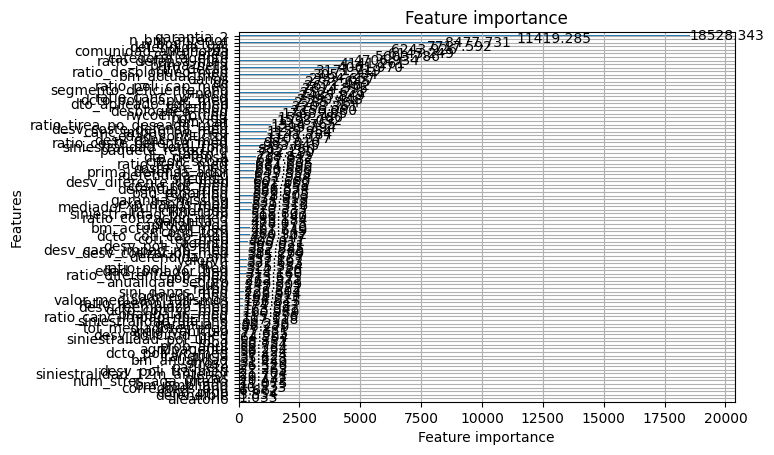

In [44]:
top_30_features, df_selected = lgbm_feature_importance(DF, "frfinal")

In [45]:
top_30_features.head(10)

,Value,Feature
123,154,comunidad_autonoma
122,153,garantia_2
121,96,segmento_deficiente_bnd
120,85,ratio_defensa_med
119,82,prima_neta
118,68,ratio_desbloqueo_med
117,67,bm_actual_med
116,62,defendida_sas
115,58,aptp_c
114,57,cltv_decile


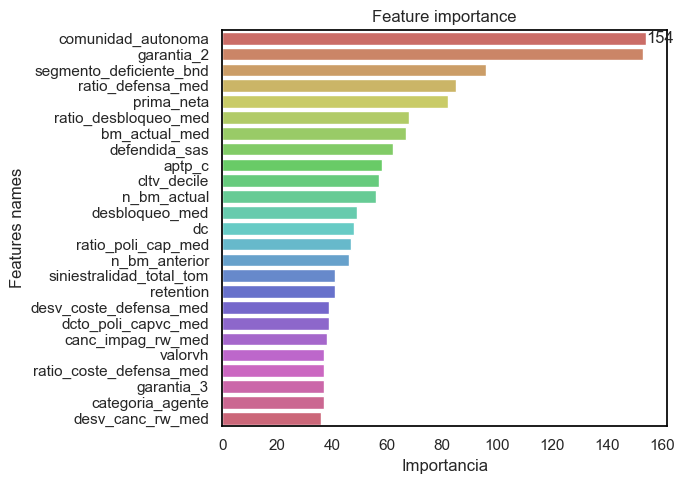

In [46]:
plot_lgb_importances(top_30_features, plot=True)

# Decision Tree

In [47]:
columns_to_select = list(set(df_selected.columns).intersection(categorical_features_2))
categorical_vars = df_Prueba[columns_to_select].columns.tolist()
print(len(categorical_vars))
categorical_vars

9


['defendida_sas',
 'aptp_c',
 'segmento_deficiente_bnd',
 'dc',
 'n_bm_anterior',
 'n_bm_actual',
 'cltv_decile',
 'categoria_agente',
 'comunidad_autonoma']

In [48]:
df_encoded = label_encode_variables(df_selected, categorical_vars)
df_encoded_all = label_encode_variables(df, categorical_vars)
df_encoded.head(5)

,comunidad_autonoma,garantia_2,segmento_deficiente_bnd,ratio_defensa_med,prima_neta,ratio_desbloqueo_med,bm_actual_med,defendida_sas,aptp_c,cltv_decile,n_bm_actual,desbloqueo_med,dc,ratio_poli_cap_med,n_bm_anterior,siniestralidad_total_tom,retention,desv_coste_defensa_med,dcto_poli_capvc_med,canc_impag_rw_med,valorvh,ratio_coste_defensa_med,garantia_3,categoria_agente,desv_canc_rw_med,defendida_sas_LabelEncoded,aptp_c_LabelEncoded,segmento_deficiente_bnd_LabelEncoded,dc_LabelEncoded,n_bm_anterior_LabelEncoded,n_bm_actual_LabelEncoded,cltv_decile_LabelEncoded,categoria_agente_LabelEncoded,comunidad_autonoma_LabelEncoded
1410643,extremadura,111,Die.B,0.230769,325.96,0.680000,8.964912,N,Menor 90%,6.0,3,34.0,29,0.460000,4,33.52,0.762975,0.039175,17.0,118.0,25000,3.153800,113,2-Corredor START,0.675017,1,20,1,7,4,2,5,1,13
734495,castilla_y_leon,117,Gas.BM>=2.NM>4.Anu2,0.128361,332.37,1.695312,10.754513,N,Menor 60%,9.0,14,217.0,24,0.570312,16,13.13,0.704991,1.717822,33.0,459.0,23400,45.716094,118,3-Corredor FIRST,3.129151,1,17,27,3,16,13,8,2,8
973351,extremadura,0,Resto,0.399135,339.67,2.348361,7.572664,N,Menor 130%,9.0,1,573.0,29,0.323770,1,9.63,0.762986,2.558034,147.0,152.0,43273,68.076516,0,3-Corredor FIRST,2.215493,1,6,28,7,1,0,8,2,13
697781,castilla_y_leon,0,Resto,0.091743,876.30,1.953668,1.333333,N,Menor 110%,6.0,4,3.0,22,0.435897,5,90.97,0.717047,1.372865,17.0,39.0,28800,102.928857,0,-Ninguno,1.222361,1,4,28,1,5,3,5,0,8
678400,baleares,0,Resto,0.208333,513.41,5.000000,10.414894,N,Menor 140%,5.0,1,5.0,24,0.435897,1,61.93,0.790120,13.893678,1.0,6.0,36420,369.750000,0,2-Corredor START,17.791254,1,7,28,3,1,0,4,1,4


In [49]:
df_encoded_VF = df_encoded.copy()
df_encoded_VF = df_encoded_VF.drop(categorical_vars, axis=1)
df_encoded_VF.head(5)

,garantia_2,ratio_defensa_med,prima_neta,ratio_desbloqueo_med,bm_actual_med,desbloqueo_med,ratio_poli_cap_med,siniestralidad_total_tom,retention,desv_coste_defensa_med,dcto_poli_capvc_med,canc_impag_rw_med,valorvh,ratio_coste_defensa_med,garantia_3,desv_canc_rw_med,defendida_sas_LabelEncoded,aptp_c_LabelEncoded,segmento_deficiente_bnd_LabelEncoded,dc_LabelEncoded,n_bm_anterior_LabelEncoded,n_bm_actual_LabelEncoded,cltv_decile_LabelEncoded,categoria_agente_LabelEncoded,comunidad_autonoma_LabelEncoded
1410643,111,0.230769,325.96,0.680000,8.964912,34.0,0.460000,33.52,0.762975,0.039175,17.0,118.0,25000,3.153800,113,0.675017,1,20,1,7,4,2,5,1,13
734495,117,0.128361,332.37,1.695312,10.754513,217.0,0.570312,13.13,0.704991,1.717822,33.0,459.0,23400,45.716094,118,3.129151,1,17,27,3,16,13,8,2,8
973351,0,0.399135,339.67,2.348361,7.572664,573.0,0.323770,9.63,0.762986,2.558034,147.0,152.0,43273,68.076516,0,2.215493,1,6,28,7,1,0,8,2,13
697781,0,0.091743,876.30,1.953668,1.333333,3.0,0.435897,90.97,0.717047,1.372865,17.0,39.0,28800,102.928857,0,1.222361,1,4,28,1,5,3,5,0,8
678400,0,0.208333,513.41,5.000000,10.414894,5.0,0.435897,61.93,0.790120,13.893678,1.0,6.0,36420,369.750000,0,17.791254,1,7,28,3,1,0,4,1,4


## Isolation Tree

In [50]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

modelo_isof = IsolationForest(
                n_estimators  = 2000,
                max_samples   ='auto',
                contamination = 0.2,
                n_jobs        = -1,
                random_state  = 42)

modelo_isof.fit(X = df_encoded_VF)

IsolationForest(contamination=0.2, n_estimators=2000, n_jobs=-1,
                random_state=42)

In [51]:
# predict the labels (1 for inliers, -1 for outliers)
y_pred = modelo_isof.predict(df_encoded_VF)

In [52]:
y_pred

array([ 1, -1,  1, ...,  1, -1,  1])

In [53]:
# get unique values and their counts
unique, counts = np.unique(y_pred, return_counts=True)

# print the counts
print(dict(zip(unique, counts)))

{-1: 176353, 1: 705411}


## Valores Atipicos

In [54]:
print(len(df_Prueba))
print(len(y_pred))

881764
881764


In [55]:
df_Prueba['val_atipicos'] = y_pred
df_Prueba.head(5)

,prima_neta,prima_reemplazante,sinocu,siniestralidad_pol_12m,prima_defensa_adpr,siniestralidad_pol_ult_3,siniestralidad_total_tom,edad_conductor,retention,tp_c,num_stros_ultaño,num_stros_aga_ultaño,total_stros_ultaño,siniestralidad_12m_anterior,garantia_1,garantia_2,garantia_3,garantia_4,garantia_5,garantia_6,garantia_7,garantia_8,cilindrada,valorvh,plazas,antig_vehiculo,mediador_principal_med,coti_tec_med,poli_med,bm_actual_med,bm_actual_pol_med,dto_aplicado_coti_med,dcto_coti_cap_med,dcto_coti_vc_med,dcto_poli_vc_med,dcto_poli_capvc_med,prianualac_med,canc_impag_rw_med,exp_med,coste_tot_med,coste_rc_med,sini_danos_med,exp_danos_med,desbloqueo_med,defendida_med,defendible_med,ratio_defensa_med,tot_mediadores_med,ratio_cotizacion_med,ratio_reemplazo_med,ratio_bm_med,ratio_tirea_no_deseado_med,ratio_diferente_cp_med,ratio_poli_cap_med,ratio_poli_vc_med,ratio_poli_tra_med,ratio_canc_rw_med,ratio_canc_impag_nb_med,ratio_coste_defensa_med,ratio_fracc_med,ratio_desbloqueo_med,ratio_desbl_menores_med,desv_solicitud_med,desv_cotizacion_med,desv_reemplazo_med,desv_diferente_cp_med,desv_poli_vc_med,desv_poli_tra_med,desv_canc_rw_med,desv_canc_impag_nb_med,desv_coste_defensa_med,aplica,ramo,paq_reporting,agrupacm,agente,dc,sucursal,uso,categoria_agente,agrupagente,n_bm_anterior,n_bm_actual,dto_defensa,corredor_piloto,anualidad_seguro,aptp_c,rwcoeff_forced,valor_mediador_turismos,prob_anul,codmedp_bnd,prueba_piloto_bnd,super_rentables_bnd,corredores_bnd,cltv_decile,aleatorio,segmento_deficiente_bnd,captotal_vida,edad_tomador_bnd,empleados,pol_vida,bm_anualidad,bm_cat,defendible,bm_ampliado,stros2,credit_score,siniestralidad_ult_ano,defendida_sas,defendida_ant,paquete_reporting,garantia_missing,sex,asistencia,cond_tom,cond_prop,matricula,clasevh,robo,danos,franquicia,paquete,canal_med,comunidad_autonoma,frfinal,val_atipicos
1410643,325.96,0.0,0.0,0.00,0.0,49.22,33.52,51.0,0.762975,320.760333,0.0,0.0,0.0,0.0,0,111,113,0,0,0,0,0,1896,25000,5,19,33782.0,108.0,50.0,8.964912,7.938776,0.023977,82.0,5.0,2.0,17.0,22885.56,118.0,31.181750,22821.32,12127.64,7.0,3.407421,34.0,15.0,65.0,0.230769,7464.0,0.631579,0.027668,7.938776,0.440000,0.260000,0.460000,0.040000,0.863636,4.080000,0.800000,3.153800,0.680000,0.680000,0.680000,2.566183,2.526585,1.913681,3.232946e-06,1.179672,2.931080,0.675017,3.668887,0.039175,0,1289,121.0,1020,33782,29,506,T 10,2-Corredor START,89-CONDICIONES ESPECIALES DEFENSA CARTERA,4,3,0,0,3.0,Menor 90%,999.0,N,Media,Resto,1.0,Resto,Resto,6.0,Sí,Die.B,Resto,04. 46 a 60,Resto,No Pol Vida,ZZ,ZZ,N,999.0,999 - NaN,6,0.0,N,N,121-Basico + Robo,6,Mujer,S,S,N,3832CVB,T,999 - NaN,999 - NaN,N,2,C,extremadura,0.0,1
734495,332.37,0.0,0.0,0.00,0.0,0.00,13.13,38.0,0.704991,515.272071,0.0,0.0,0.0,0.0,0,117,118,0,0,0,0,0,1598,23400,7,6,501023.0,281.0,128.0,10.754513,8.093750,0.086173,482.0,3.0,4.0,33.0,66821.49,459.0,777.985623,505542.26,128646.71,44.0,97.046728,217.0,148.0,1153.0,0.128361,7510.0,0.338147,0.039062,8.093750,0.406250,0.187500,0.570312,0.031250,0.007812,6.859375,0.179688,45.716094,0.101562,1.695312,1.695312,2.566183,1.536746,6.428772,9.085227e-07,1.463432,0.025657,3.129151,2.326895,1.717822,0,1289,121.0,1020,501023,24,125,T 10,3-Corredor FIRST,89-CONDICIONES ESPECIALES DEFENSA CARTERA,16,14,0,0,2.0,Menor 60%,999.0,N,Media,DC 24,1.0,Resto,Resto,9.0,Sí,Gas.BM>=2.NM>4.Anu2,999 - NaN,999 - NaN,Resto,999 - NaN,999 - NaN,999 - NaN,N,999.0,999 - NaN,999 - NaN,2.0,N,N,121-Basico + Robo,6,Mujer,S,S,S,3900KFJ,T,999 - NaN,999 - NaN,N,2,C,castilla_y_leon,0.0,-1
973351,339.67,0.0,0.0,146.61,0.0,156.51,9.63,48.0,0.762986,242.571159,1.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,2148,43273,6,15,8250014.0,259.0,244.0,7.572664,5.118852,0.137059,1298.0,4.0,2.0,147.0,72201.53,152.0,614.082615,544707.38,77610.49,51.0,120.439794,573.0,554.0,1388.0,0.399135,7510.0,0.074683,0.027668,5.118852,0.139344,0.069672,0.323770,0.008197,0.863636,4.856557,0.073770,68.076516,0.036885,2.348361,2.348361,2.566183,0.339404,1.913681,3.375931e-07,0.383851,2.931080,2.215493,0.955304,2.55

In [56]:
df_Prueba.frfinal[df_Prueba.val_atipicos == -1].value_counts()

frfinal
0.0    172250
1.0      4103
Name: count, dtype: int64

### Arbol Prueba

In [57]:
df_encoded_VF['val_atipicos'] = y_pred

In [58]:
Prueba_arbol = df_encoded_VF[df_encoded_VF.val_atipicos == -1]

In [59]:
Prueba_arbol = Prueba_arbol.drop(columns=["val_atipicos"])

In [60]:
len(Prueba_arbol)

176353

Accuracy: 0.47049984406452894
AUC: 0.7218509941326111
F1 score: 0.07010555666201952
F2 score: 0.3363519719151936


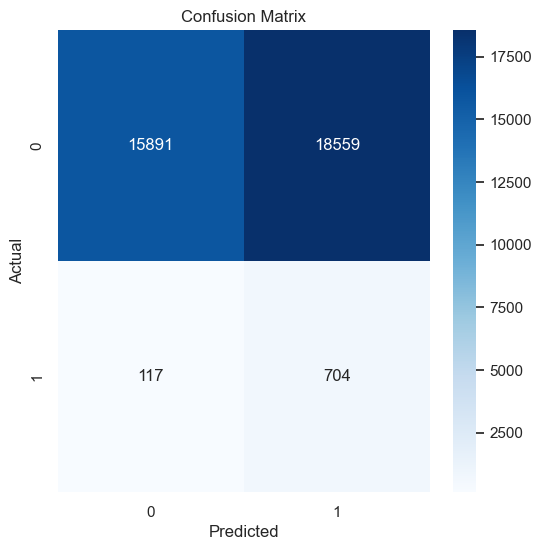

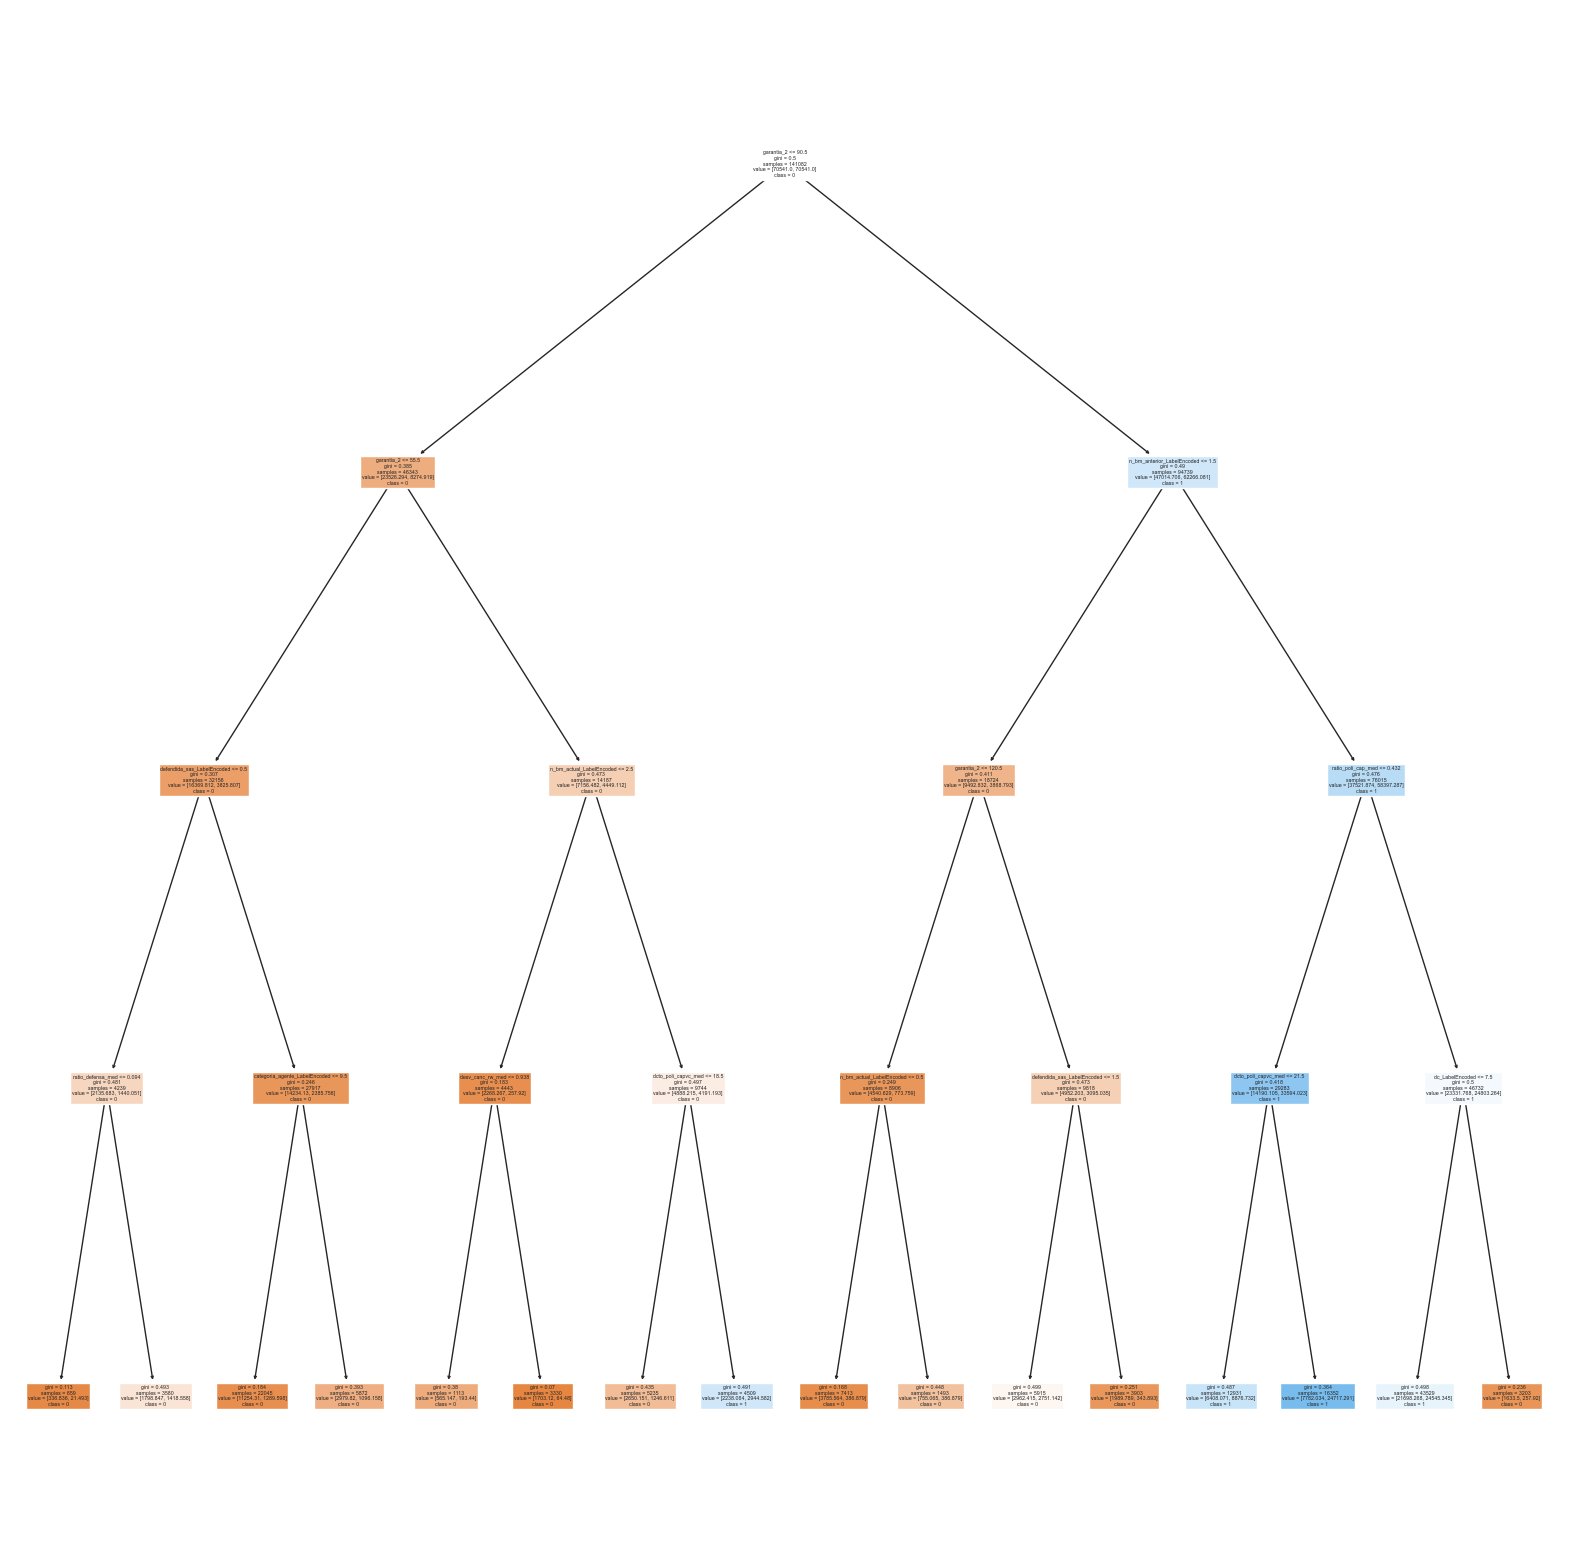

|--- garantia_2 <= 90.50
|   |--- garantia_2 <= 55.50
|   |   |--- defendida_sas_LabelEncoded <= 0.50
|   |   |   |--- ratio_defensa_med <= 0.09
|   |   |   |   |--- class: 0.0
|   |   |   |--- ratio_defensa_med >  0.09
|   |   |   |   |--- class: 0.0
|   |   |--- defendida_sas_LabelEncoded >  0.50
|   |   |   |--- categoria_agente_LabelEncoded <= 9.50
|   |   |   |   |--- class: 0.0
|   |   |   |--- categoria_agente_LabelEncoded >  9.50
|   |   |   |   |--- class: 0.0
|   |--- garantia_2 >  55.50
|   |   |--- n_bm_actual_LabelEncoded <= 2.50
|   |   |   |--- desv_canc_rw_med <= 0.94
|   |   |   |   |--- class: 0.0
|   |   |   |--- desv_canc_rw_med >  0.94
|   |   |   |   |--- class: 0.0
|   |   |--- n_bm_actual_LabelEncoded >  2.50
|   |   |   |--- dcto_poli_capvc_med <= 18.50
|   |   |   |   |--- class: 0.0
|   |   |   |--- dcto_poli_capvc_med >  18.50
|   |   |   |   |--- class: 1.0
|--- garantia_2 >  90.50
|   |--- n_bm_anterior_LabelEncoded <= 1.50
|   |   |--- garantia_2 <= 120.5

In [61]:
model = decision_tree_model(target = 'frfinal', df_selected = Prueba_arbol, df = DF, min_samples_leaf = 400, max_depth = 4)

In [62]:
X_test = Prueba_arbol.drop(columns=["frfinal"])
X_test

,garantia_2,ratio_defensa_med,prima_neta,ratio_desbloqueo_med,bm_actual_med,desbloqueo_med,ratio_poli_cap_med,siniestralidad_total_tom,retention,desv_coste_defensa_med,dcto_poli_capvc_med,canc_impag_rw_med,valorvh,ratio_coste_defensa_med,garantia_3,desv_canc_rw_med,defendida_sas_LabelEncoded,aptp_c_LabelEncoded,segmento_deficiente_bnd_LabelEncoded,dc_LabelEncoded,n_bm_anterior_LabelEncoded,n_bm_actual_LabelEncoded,cltv_decile_LabelEncoded,categoria_agente_LabelEncoded,comunidad_autonoma_LabelEncoded
734495,117,0.128361,332.37,1.695312,10.754513,217.0,0.570312,13.13,0.704991,1.717822,33.0,459.0,23400,45.716094,118,3.129151,1,17,27,3,16,13,8,2,8
1257887,0,0.531207,515.66,12.981132,7.023333,688.0,0.452830,29.76,0.762975,1.144628,26.0,195.0,18383,214.996981,0,1.330703,2,7,28,0,1,0,9,8,14
950219,99,0.148936,334.69,0.980000,8.438740,147.0,0.435897,0.00,0.371906,0.172606,17.0,320.0,14052,4.593533,0,1.979847,1,18,26,0,8,6,5,9,17
1641503,101,0.165049,316.91,11.000000,6.763889,88.0,0.125000,495.89,0.762975,1.547458,7.0,181.0,8504,124.578750,101,6.018075,1,3,13,7,6,4,3,2,8
679491,126,0.054054,1302.45,0.184783,7.979124,17.0,0.913043,36.50,0.521212,0.019409,7.0,50.0,122800,0.516522,123,0.609901,1,6,15,7,3,3,4,2,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853656,124,0.562762,818.76,8.360000,11.896787,209.0,0.360000,43.15,0.762975,3.156867,13.0,220.0,40250,256.223200,124,2.814770,1,16,15,7,15,13,8,2,7
1853792,91,0.308605,944.44,1.953668,2.000000,1.0,0.435897,0.00,0.762975,1.372865,17.0,73.0,11400,102.928857,0,1.222361,1,18,26,7,20,21,9,0,13
1854090,142,0.228519,392.53,5.287129,8.462433,1068.0,0.128713,-18.70,0.762975,0.170958,171.0,487.0,22810,32.385792,0,0.582615,1,19,6,6,4,2,4,0,17
1855250,140,0.637427,559.10,3.829268,8.659205,157.0,0.414634,23.25,0.762975,0.307786,14.0,95.0,17056,58.306098,0,0.644278,1,20,5,7,15,13,5,4,10


In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#scaler = StandardScaler()
#X_test = scaler.fit_transform(X_test)

In [64]:
#explainer = shap.TreeExplainer(model)

In [65]:
#shap_values = explainer.shap_values(X_test)

In [66]:
#shap.summary_plot(shap_values, X_test)

In [70]:
explainer = shap.Explainer(model.predict, X_test)
## explainer = shap.Explainer(model)
#shap_values = explainer(X_test)
shap_values = explainer.shap_values(X_test)

PermutationExplainer explainer: 176354it [14:31, 199.79it/s]                                                                                                                       


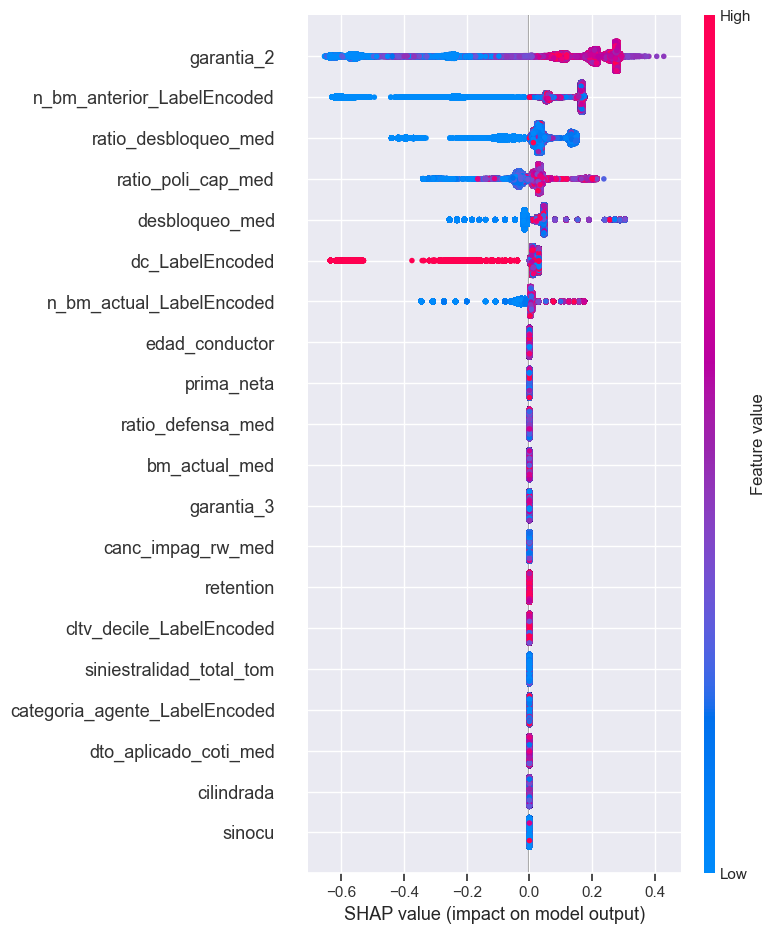

In [72]:
shap.summary_plot(shap_values, X_test)
#shap.plots.beeswarm(shap_values.values)

In [ ]:
total_count = df_encoded_all['frfinal'].value_counts()

filters = [
    df_encoded_all['n_bm_anterior_LabelEncoded'] >= 2.5,
    (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 2.5) & (df_encoded_all['garantia_2'] >= 59.5),
    (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 2.5) & (df_encoded_all['garantia_2'] >= 59.5) & (df_encoded_all['ratio_poli_cap_med'] <= 0.43),
    (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 2.5) & (df_encoded_all['garantia_2'] >= 59.5) & (df_encoded_all['ratio_poli_cap_med'] <= 0.43) & (df_encoded_all['ratio_desbloqueo_med'] >= 0.64),
    (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 2.5) & (df_encoded_all['garantia_2'] >= 59.5) & (df_encoded_all['ratio_poli_cap_med'] <= 0.43) & (df_encoded_all['ratio_desbloqueo_med'] <= 0.64),
    (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 2.5) & (df_encoded_all['garantia_2'] >= 59.5) & (df_encoded_all['ratio_poli_cap_med'] >= 0.43),
    (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 2.5) & (df_encoded_all['garantia_2'] >= 59.5) & (df_encoded_all['ratio_poli_cap_med'] >= 0.43) & (df_encoded_all['ratio_defensa_med'] >= 0.11),
    (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 2.5) & (df_encoded_all['garantia_2'] >= 59.5) & (df_encoded_all['ratio_poli_cap_med'] >= 0.43) & (df_encoded_all['ratio_defensa_med'] <= 0.11)
]

data = {
    'FR': [],
    'No_FR': [],
    '% BBDD FR': [],
    '% BBDD No_FR': [],
    '% BBDD': []
}

for filter in filters:
    filtered_df = df_encoded_all[['frfinal']][filter]
    value_counts = filtered_df['frfinal'].value_counts()

    data['FR'].append(value_counts.get(1.0, 0))
    data['No_FR'].append(value_counts.get(0.0, 0))
    data['% BBDD FR'].append((value_counts.get(1.0, 0) / total_count.get(1.0, 0)) * 100)
    data['% BBDD No_FR'].append((value_counts.get(0.0, 0) / total_count.get(0.0, 0)) *100)
    data['% BBDD'].append((value_counts.sum() / total_count.sum()) *100)

# Create the DataFrame
#FR_df = pd.DataFrame(data, index=['Rama1', 'Rama2', 'Rama3', 'Hoja1', 'Hoja2', 'Hoja3', 'Rama5', 'Rama6'])
FR_df = pd.DataFrame(data, index=['Rama1', 'Rama2', 'Rama3', 'Hoja3', 'Hoja4', 'Rama4', 'Hoja1', 'Hoja2'])

print(FR_df)

In [90]:
total_count = df_encoded_all['frfinal'].value_counts()

filters = [
    df_encoded_all['n_bm_anterior_LabelEncoded'] >= 1.5,
    (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 1.5) & (df_encoded_all['garantia_2'] >= 55.5),
    (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 1.5) & (df_encoded_all['garantia_2'] >= 55.5) & (df_encoded_all['ratio_defensa_med'] >= 0.1),
    (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 1.5) & (df_encoded_all['garantia_2'] >= 55.5) & (df_encoded_all['ratio_defensa_med'] >= 0.1) & (df_encoded_all['desbloqueo_med'] >= 74.5), 
    (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 1.5) & (df_encoded_all['garantia_2'] >= 55.5) & (df_encoded_all['ratio_defensa_med'] >= 0.1) & (df_encoded_all['desbloqueo_med'] <= 74.5),
    (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 1.5) & (df_encoded_all['garantia_2'] >= 55.5) & (df_encoded_all['ratio_defensa_med'] <= 0.1) & (df_encoded_all['canc_impag_rw_med'] <= 234.5),
    (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 1.5) & (df_encoded_all['garantia_2'] <= 55.5) & (df_encoded_all['defendida_sas_LabelEncoded'] <= 0.5),
    (df_encoded_all['n_bm_anterior_LabelEncoded'] <= 1.5) & (df_encoded_all['garantia_2'] >= 120.5) & (df_encoded_all['ratio_defensa_med'] >= 0.4)
    
    #(df_encoded_all['garantia_2'] >= 89.5) & (df_encoded_all['n_bm_actual_LabelEncoded'] >= 1.5) & (df_encoded_all['ratio_desbloqueo_med'] <= 1.17) & (df_encoded_all['n_bm_anterior_LabelEncoded'] <= 8.5),
    #(df_encoded_all['garantia_2'] >= 89.5) & (df_encoded_all['n_bm_actual_LabelEncoded'] <= 1.5) & (df_encoded_all['garantia_2'] >= 165.5) & (df_encoded_all['defendida_sas_LabelEncoded'] <= 1.5),
    #(df_encoded_all['garantia_2'] <= 89.5) & (df_encoded_all['garantia_2'] <= 55.5) & (df_encoded_all['defendida_sas_LabelEncoded'] <= 0.5) & (df_encoded_all['cltv_decile_LabelEncoded'] >= 6.5)
    
    #(df_encoded_all['garantia_2'] >= 89.5) & (df_encoded_all['garantia_2'] >= 115.5) & (df_encoded_all['defendida_sas_LabelEncoded'] >= 1.5), 
    #(df_encoded_all['garantia_2'] <= 89.5) & (df_encoded_all['garantia_2'] >= 55.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 4.5),
    #(df_encoded_all['garantia_2'] <= 89.5) & (df_encoded_all['garantia_2'] <= 55.5) & (df_encoded_all['defendida_sas_LabelEncoded'] <= 0.5) 
]

data = {
    'FR': [],
    'No_FR': [],
    '% BBDD FR': [],
    '% BBDD No_FR': [],
    '% BBDD': []
}

for filter in filters:
    filtered_df = df_encoded_all[['frfinal']][filter]
    value_counts = filtered_df['frfinal'].value_counts()

    data['FR'].append(value_counts.get(1.0, 0))
    data['No_FR'].append(value_counts.get(0.0, 0))
    data['% BBDD FR'].append((value_counts.get(1.0, 0) / total_count.get(1.0, 0)) * 100)
    data['% BBDD No_FR'].append((value_counts.get(0.0, 0) / total_count.get(0.0, 0)) *100)
    data['% BBDD'].append((value_counts.sum() / total_count.sum()) *100)

# Create the DataFrame
FR_df = pd.DataFrame(data, index=['Rama1', 'Rama2', 'Rama3', 'Hoja1', 'Hoja2', 'Hoja3', 'Rama5', 'Rama6'])

print(FR_df)

         FR   No_FR  % BBDD FR  % BBDD No_FR     % BBDD
Rama1  9076  646612  69.617243     40.760915  40.996130
Rama2  8763  539581  67.216384     34.013930  34.284571
Rama3  8371  480457  64.209557     30.286891  30.563402
Hoja1  5536  250390  42.463757     15.784003  16.001476
Hoja2  2835  230067  21.745800     14.502888  14.561927
Hoja3   360   47661   2.761371      3.004438   3.002457
Rama5   107   10208   0.820741      0.643489   0.644933
Rama6   822   81955   6.305132      5.166252   5.175536


In [ ]:
## Label 

In [66]:
df_encoded_all['n_bm_actual'][df_encoded_all.n_bm_actual_LabelEncoded <= 1.5].value_counts()

n_bm_actual
1    1003019
0          1
Name: count, dtype: int64

In [91]:
df_encoded_all['n_bm_actual'].value_counts()

n_bm_actual
1     1003019
2      117965
3       97438
4       67049
5       52108
6       40477
7       35761
8       30665
9       27928
10      23512
13      22492
14      20804
11      19575
12      19163
15       6678
16       5093
17       3072
18       3044
19       1145
20        976
22        560
21        479
24        230
23        156
0           1
Name: count, dtype: int64

In [ ]:
## Check

In [112]:
value_to_check = 'T 10'

columns_with_value = X.apply(lambda column: value_to_check in column.values)

try:
    columns_with_value_true = columns_with_value[columns_with_value].index.tolist()
except ValueError:
    columns_with_value_true = columns_with_value[columns_with_value].apply(
        lambda x: np.nan if isinstance(x, str) and x != value_to_check else x
    ).dropna(how='all').index.tolist()

print(columns_with_value_true)

['uso']
